In [1]:
import os
import re
import json
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
%matplotlib inline

In [3]:
NAME_REGEX = r"((checkpoint|events|args).*)|(report-dev-m(?P<d>1|0,1|0,0,1)-(?P<s>[0-9]*)-(?P<t>train|eval)\.jsonl)"
DIST_TO_NUMBER = {"1" : 1, "0,1" : 2, "0,0,1" : 3}

In [4]:
def table_of_accuracies(logdir):
    data = []
    rel_logdir = os.path.join("..", logdir)
    for f in os.listdir(rel_logdir):
        m = re.match(NAME_REGEX, f)
        assert m, "{} not a valid name".format(f)
        if not m.group("d"):
            continue
        distance = DIST_TO_NUMBER[m.group("d")]
        checkpoint = int(m.group("s"))
        datatype = m.group("t")
        with open(os.path.join(rel_logdir, f)) as fp:
            stats = json.loads(next(fp))
        if stats['total'] < 2500:
            print(os.path.join(logdir, f))
            print(stats)
            continue
        data.append([distance, checkpoint, stats['correct'] / stats['total'], datatype])
    df = pd.DataFrame(
        data, columns=['Distance', 'Step', 'Accuracy', 'DataType']
    )
    train, val = df[df['DataType'] == 'train'], df[df['DataType'] == 'eval']
    pivot = lambda x: x.pivot(index='Step', columns='Distance', values='Accuracy')
    return pivot(train), pivot(val)

In [5]:
def plot_accuracies(train_val):
    COLORS = plt.rcParams['axes.prop_cycle'].by_key()['color']
    def plot(accuracies, label, fmt):
        assert len(list(accuracies)) <= len(COLORS)
        for i, dist in enumerate(accuracies):
            plt.plot(accuracies[dist] * 100, fmt, label="{}, Distance={}".format(label, dist), color=COLORS[i])
        plt.xlabel("Step")
        plt.ylabel("Accuracy [%]")
        plt.legend()
    plot(train_val[0], label='train', fmt='-')
    plot(train_val[1], label='val', fmt='--')

def plot_combined_accuracy(table, label):
    plt.plot((table[1] + table[2] + table[3]) * 100 / 3, label=label)
    plt.xlabel("Step")
    plt.ylabel("Accuracy [%]")
    plt.legend()


In [6]:
vanilla_accuracies = table_of_accuracies("logdirs/vanilla,trace_enc==none,batch_size==64,lr==1,lr_decay_steps=100000/")

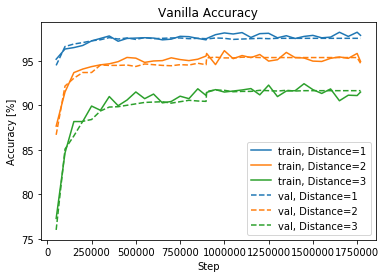

In [7]:
plot_accuracies(vanilla_accuracies)
plt.title("Vanilla Accuracy")
plt.show()

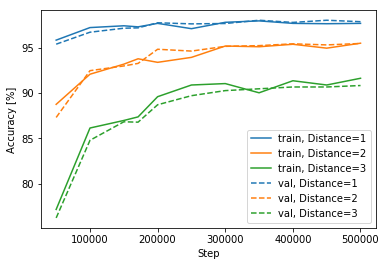

In [8]:
trace_accuracies = table_of_accuracies("logdirs/aggregate-standard,trace_enc==aggregate,batch_size==64,lr==1,lr_decay_steps=100000/")
plot_accuracies(trace_accuracies)

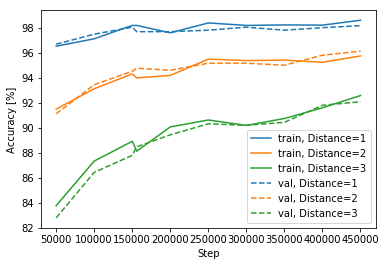

In [9]:
trace_accuracies_with_io = table_of_accuracies("logdirs/aggregate-with-io,trace_enc==aggregate:conv_all_grids=True,batch_size==64,lr==1,lr_decay_steps=100000")
plot_accuracies(trace_accuracies_with_io)

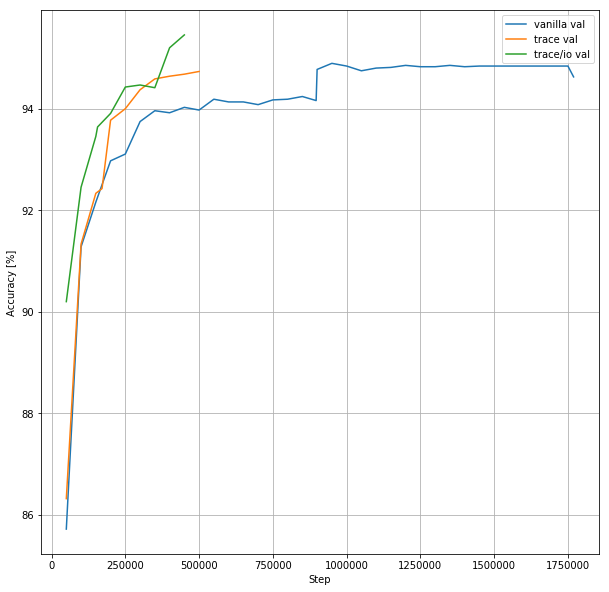

In [10]:
plt.figure(figsize=(10, 10))
# plot_combined_accuracy(vanilla_accuracies[0], "vanilla train")
plot_combined_accuracy(vanilla_accuracies[1], "vanilla val")
# plot_combined_accuracy(trace_accuracies[0], "trace train")
plot_combined_accuracy(trace_accuracies[1], "trace val")
# plot_combined_accuracy(trace_accuracies_with_io[0], "trace/io train")
plot_combined_accuracy(trace_accuracies_with_io[1], "trace/io val")
# plt.axhline(95)
plt.grid()
plt.show()